In [17]:
%cd drive/MyDrive/Colab\ Notebooks/HouseholdDebt

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/HouseholdDebt'
/content/drive/MyDrive/Colab Notebooks/HouseholdDebt


# 한글세팅

In [2]:
!sudo apt-get update -qq
!sudo apt-get install fonts-nanum* -qq

In [3]:
%matplotlib inline  

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도

In [4]:
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)

NanumBarunGothic


In [5]:
plt.rc('font', family=font_name)
fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

In [6]:
import seaborn as sns

In [7]:
sns.set(font=font_name, 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [8]:
import pandas as pd

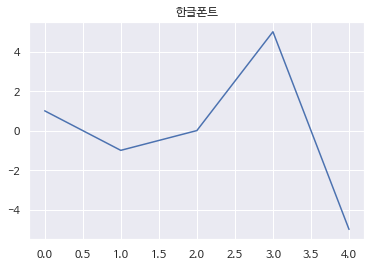

In [9]:
pd.Series([1, -1, 0, 5, -5]).plot(title="한글폰트")
None

In [10]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 5.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# 20대 전세자금대출 VECM


In [11]:
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import *

## Data load

In [45]:
df = pd.read_csv('data/all_macro_data.csv', index_col=0)

In [46]:
df = df.join([pd.read_csv('data/charter_macro_data.csv', index_col=0)])

In [47]:
df_ur = pd.read_csv('data/실업률.csv')

In [48]:
df['unemployment_rate'] = list(df_ur[(df_ur['성별']=='계') & (df_ur['연령계층별']=='20 - 29세')]['데이터'])

In [49]:
df_loan = pd.read_csv('data/house_loan.csv')

In [50]:
df_loan['대출금액합계<미적용, 십만원>'].unique()

array([    60,   2679,   4988, ..., 225971,   5861,  57224])

In [51]:
df['charter_loan_20'] = df_loan[(df_loan['연령대'] == '20대') & (df_loan['상품구분(KFB)명'].isin(['전세자금(보증서, 질권 등)대출', '전세자금대출', '전세보증금담보대출']))].groupby('기준분기').sum()['대출금액합계<미적용, 십만원>']

In [52]:
from sklearn.preprocessing import StandardScaler
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns, index=df.index)

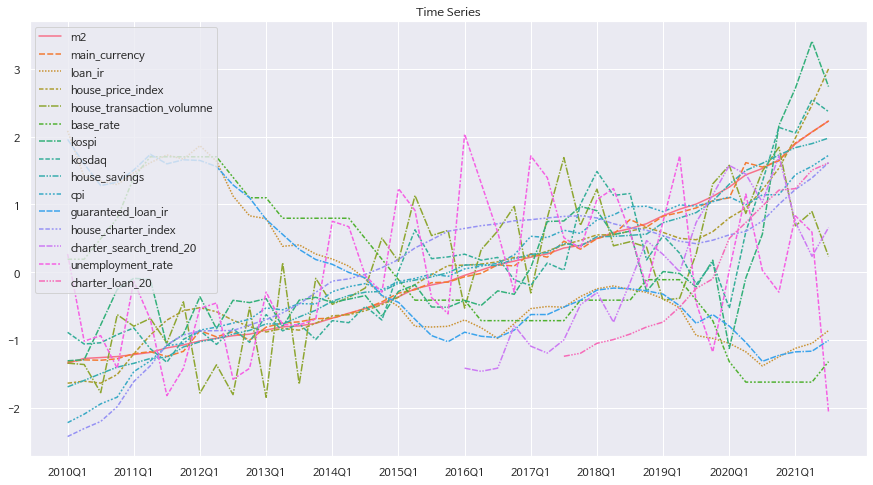

In [53]:
plt.figure(figsize = (15,8))
ax = sns.lineplot(data=df_scaled)
ax.set_title('Time Series')
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 4 != 0:
        xticks[i].set_visible(False)
plt.show()
None

In [54]:
df = df[['house_savings', 'guaranteed_loan_ir', 'unemployment_rate', 'cpi', 'house_charter_index', 'charter_search_trend_20' ,'charter_loan_20']]

In [55]:
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns, index=df.index)

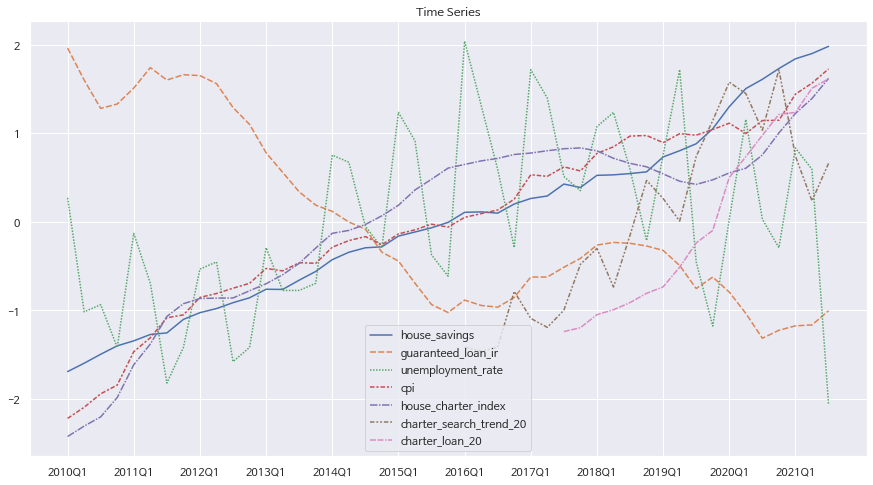

In [56]:
plt.figure(figsize = (15,8))
ax = sns.lineplot(data=df_scaled)
ax.set_title('Time Series')
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 4 != 0:
        xticks[i].set_visible(False)
plt.show()
None

In [57]:
df = df[30:]

In [58]:
df.columns

Index(['house_savings', 'guaranteed_loan_ir', 'unemployment_rate', 'cpi',
       'house_charter_index', 'charter_search_trend_20', 'charter_loan_20'],
      dtype='object')

In [60]:
for col in df.columns:
  if col in ['guaranteed_loan_ir', 'unemployment_rate']:
    print(col)
    continue
  df[col] = df[col].apply(np.log)

guaranteed_loan_ir
unemployment_rate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


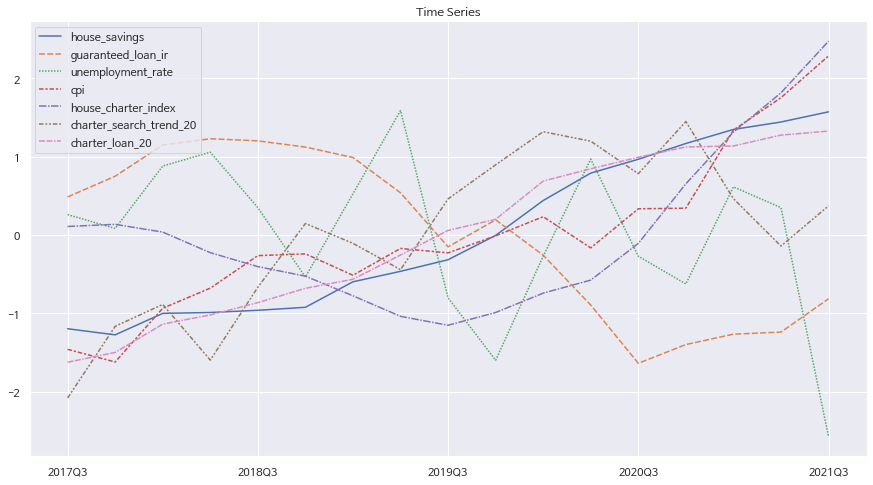

In [61]:
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns, index=df.index)
plt.figure(figsize = (15,8))
ax = sns.lineplot(data=df_scaled)
ax.set_title('Time Series')
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 4 != 0:
        xticks[i].set_visible(False)
plt.show()
None

## Unit root test

In [34]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [62]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "house_savings" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.6147
 No. Lags Chosen       = 6
 Critical value 1%     = -4.332
 Critical value 5%     = -3.233
 Critical value 10%    = -2.749
 => P-Value = 0.9979. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "guaranteed_loan_ir" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.5839
 No. Lags Chosen       = 0
 Critical value 1%     = -3.924
 Critical value 5%     = -3.068
 Critical value 10%    = -2.674
 => P-Value = 0.8746. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "unemployment_rate" 
    -----------------------------------------------

In [63]:
for name, column in df.diff().dropna().iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "house_savings" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.2926
 No. Lags Chosen       = 6
 Critical value 1%     = -4.473
 Critical value 5%     = -3.29
 Critical value 10%    = -2.772
 => P-Value = 0.0152. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "guaranteed_loan_ir" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.625
 No. Lags Chosen       = 0
 Critical value 1%     = -3.964
 Critical value 5%     = -3.085
 Critical value 10%    = -2.682
 => P-Value = 0.0879. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "unemployment_rate" 
    -----------------------------------------------
 Null Hypothesis: Data

In [64]:
for name, column in df.diff().dropna().diff().dropna().iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "house_savings" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1862
 No. Lags Chosen       = 5
 Critical value 1%     = -4.473
 Critical value 5%     = -3.29
 Critical value 10%    = -2.772
 => P-Value = 0.0208. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "guaranteed_loan_ir" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.8434
 No. Lags Chosen       = 0
 Critical value 1%     = -4.012
 Critical value 5%     = -3.104
 Critical value 10%    = -2.691
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "unemployment_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stat

## Granger's causality

In [66]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=12, verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [70]:
grangers_causation_matrix(df, variables = df.columns, maxlag=4)

,house_savings_x,guaranteed_loan_ir_x,unemployment_rate_x,cpi_x,house_charter_index_x,charter_search_trend_20_x,charter_loan_20_x
house_savings_y,1.0000,0.1623,0.0000,0.1783,0.0000,0.0000,0.0000
guaranteed_loan_ir_y,0.0000,1.0000,0.0000,0.0001,0.0000,0.0000,0.0004
unemployment_rate_y,0.0020,0.0012,1.0000,0.0000,0.0142,0.0039,0.0002
cpi_y,0.0005,0.0000,0.0000,1.0000,0.0000,0.0095,0.0000
house_charter_index_y,0.0000,0.0000,0.0000,0.0030,1.0000,0.0000,0.0000
charter_search_trend_20_y,0.0166,0.0418,0.0477,0.2652,0.0000,1.0000,0.0000
charter_loan_20_y,0.0001,0.0004,0.1141,0.0007,0.0050,0.1772,1.0000


## Cointegration rank

In [71]:
def cointegration_test(df, det_order=-1, k_ar_diff=5, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df, det_order=det_order,k_ar_diff=k_ar_diff)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [93]:
cointegration_test(df, 1, 2)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
house_savings ::  390.14    > 139.278   =>   True
guaranteed_loan_ir ::  254.19    > 107.3429  =>   True
unemployment_rate ::  158.05    > 79.3422   =>   True
cpi    ::  96.78     > 55.2459   =>   True
house_charter_index ::  50.92     > 35.0116   =>   True
charter_search_trend_20 ::  11.78     > 18.3985   =>   False
charter_loan_20 ::  1.09      > 3.8415    =>   False


In [94]:
rank_test = select_coint_rank(df, 1, 2, method="trace",
                              signif=0.05)
rank_test.rank

5

In [95]:
rank_test.summary()

r_0,r_1,test statistic,critical value
0,7,390.1,139.3
1,7,254.2,107.3
2,7,158.0,79.34
3,7,96.78,55.25
4,7,50.92,35.01
5,7,11.78,18.40


## Lag order selection

In [99]:
lag_order = select_order(data=df, maxlags=5, deterministic="ci", seasons=4)
lag_order.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local

,AIC,BIC,FPE,HQIC
0,-432.1,-429.1,-1.703e-185*,-434.0
1,-448.6*,-443.7*,-5.134e-202,-451.6*
2,-441.0,-434.4,-6.986e-204,-445.2
3,-433.4,-425.1,-4.253e-205,-438.7
4,-426.2,-416.0,-3.377e-206,-432.5
5,-411.6,-399.7,-5.224e-204,-419.1


In [81]:
lag_order = select_order(data=df, maxlags=5, deterministic='li', seasons=4)
lag_order.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local

,AIC,BIC,FPE,HQIC
0,-451.3*,-448.3*,-7.863e-194*,-453.2*
1,-446.8,-442.0,-2.914e-201,-449.9
2,-438.9,-432.3,-6.015e-203,-443.0
3,-433.7,-425.4,-3.116e-205,-439.0
4,-426.8,-416.7,-1.728e-206,-433.2
5,-416.4,-404.5,-4.088e-206,-423.9


In [85]:
lag_order = select_order(data=df, maxlags=1, deterministic='li', seasons=0)
lag_order.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,-88.50,-85.52,1.357e-38,-88.53
1,-418.7*,-413.4*,-1.269e-178*,-418.8*


In [86]:
lag_order = select_order(data=df, maxlags=5, deterministic='lo', seasons=4)
lag_order.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local

,AIC,BIC,FPE,HQIC
0,-451.3*,-448.3*,-7.863e-194*,-453.2*
1,-446.8,-442.0,-2.914e-201,-449.9
2,-438.9,-432.3,-6.015e-203,-443.0
3,-433.7,-425.4,-3.116e-205,-439.0
4,-426.8,-416.7,-1.728e-206,-433.2
5,-416.4,-404.5,-4.088e-206,-423.9


In [88]:
lag_order = select_order(data=df, maxlags=1, deterministic='lo', seasons=0)
lag_order.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,-88.50,-85.52,1.357e-38,-88.53
1,-418.7*,-413.4*,-1.269e-178*,-418.8*


## Parameter estimation

In [100]:
model = VECM(df,
             k_ar_diff=2,
             coint_rank=7,
             deterministic='lo',
             seasons=4)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


In [101]:
vecm_res = model.fit()

In [102]:
vecm_res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/vecm.py:1541: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params_default))


,coef,std err,z,P>|z|,[0.025,0.975]
season1,0.0173,9.66e+04,1.79e-07,1.000,-1.89e+05,1.89e+05
season2,-0.0010,3.5e+04,-2.75e-08,1.000,-6.86e+04,6.86e+04
season3,0.0021,1.69e+05,1.27e-08,1.000,-3.31e+05,3.31e+05
lin_trend,0.0005,4741.691,9.66e-08,1.000,-9293.543,9293.544
L1.house_savings,-0.1936,2.38e+06,-8.12e-08,1.000,-4.67e+06,4.67e+06
L1.guaranteed_loan_ir,-0.0374,2.04e+04,-1.83e-06,1.000,-4e+04,4e+04
L1.unemployment_rate,-0.0049,nan,nan,nan,nan,nan
L1.cpi,-0.2046,nan,nan,nan,nan,nan
L1.house_charter_index,0.0783,3.91e+06,2e-08,1.000,-7.66e+06,7.66e+06
L1.charter_search_trend_20,0.0102,1.33e+05,7.65e-08,1.000,-2.6e+05,2.6e+05


## Forecasts

In [103]:
vecm_res.predict(steps=5)

array([[ 15.88646729,   3.16189236,  17.86789605,   4.57288516,
          4.62554244,   4.63315938,  16.22726548],
       [ 15.8380738 ,   1.12874469,  42.54911005,   4.47206981,
          4.58757917,   4.56249337,  16.29456618],
       [ 15.63718802,  -2.20683599,  65.0230018 ,   4.2658668 ,
          4.55838642,   2.97488785,  14.17463984],
       [ 15.17205213,  -3.93770779,  88.5133878 ,   3.84262157,
          4.57040248,   4.06509798,   7.47487253],
       [ 14.41110476,  -5.91546401, 286.25527325,   2.10265329,
          4.4484968 ,   6.95498587,  -7.15211466]])

In [104]:
vecm_res.predict(steps=5, alpha=0.05)
for text, vaĺues in zip(("forecast", "lower", "upper"), vecm_res.predict(steps=5, alpha=0.05)):
    print(text+":", vaĺues, sep="\n")

forecast:
[[ 15.88646729   3.16189236  17.86789605   4.57288516   4.62554244
    4.63315938  16.22726548]
 [ 15.8380738    1.12874469  42.54911005   4.47206981   4.58757917
    4.56249337  16.29456618]
 [ 15.63718802  -2.20683599  65.0230018    4.2658668    4.55838642
    2.97488785  14.17463984]
 [ 15.17205213  -3.93770779  88.5133878    3.84262157   4.57040248
    4.06509798   7.47487253]
 [ 14.41110476  -5.91546401 286.25527325   2.10265329   4.4484968
    6.95498587  -7.15211466]]
lower:
[[ 15.8802947    3.08746354  12.7777147    4.55819072   4.61542493
    3.93551971  15.96994905]
 [ 15.77837456   0.67098009  18.39726383   4.32810749   4.56049253
    3.83887441  15.46593747]
 [ 15.43637725  -5.92777222  16.42770963   3.96267262   4.50105728
    1.68788379  11.97510109]
 [ 14.67108783 -10.84788866 -38.79637671   2.86183052   4.45945626
    1.88277598  -1.05481028]
 [ 12.70713267 -21.85660074   5.0081078   -0.2673729    4.21213062
    2.35347363 -32.1203095 ]]
upper:
[[ 15.89263988 

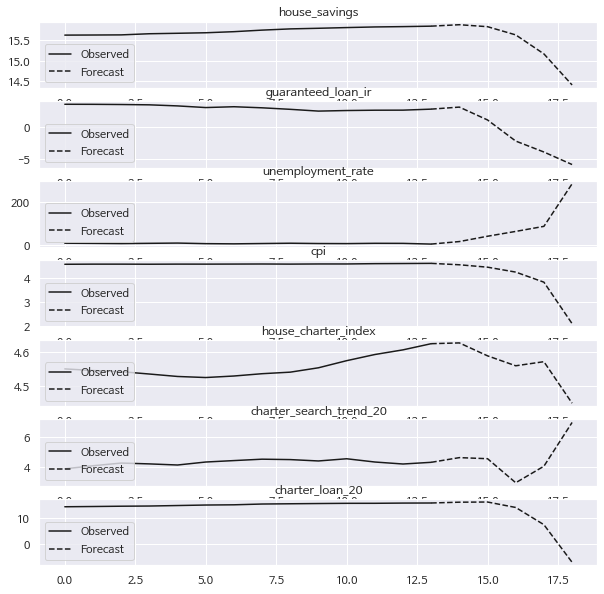

In [105]:
vecm_res.plot_forecast(steps=5, plot_conf_int=False)

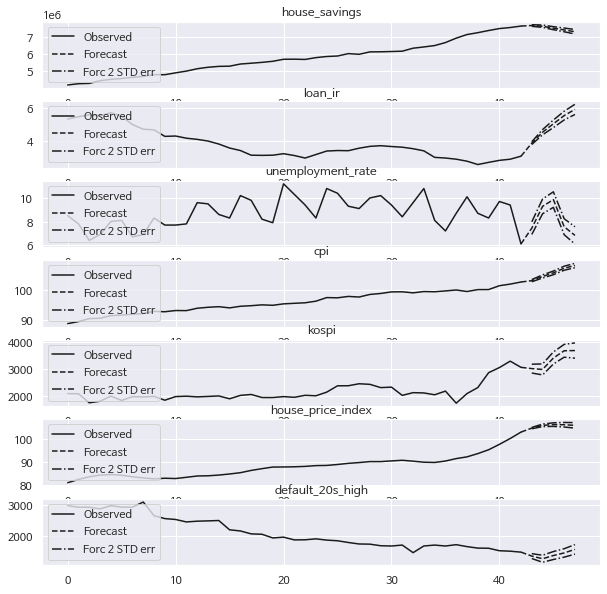

In [ ]:
vecm_res.plot_forecast(steps=5, plot_conf_int=True)

## Structural analysis

### Granger causality

In [ ]:
granger_results = vecm_res.test_granger_causality(caused="default_20s_high", causing='cpi', signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
7.979,2.840,0.000,"(4, 21)"


### Instantaneous causality

In [ ]:
inst_caus_base_rate = vecm_res.test_inst_causality(causing="cpi")
inst_caus_base_rate.summary()

Test statistic,Critical value,p-value,df
19.61,12.59,0.003,6


### Impulse response analysis

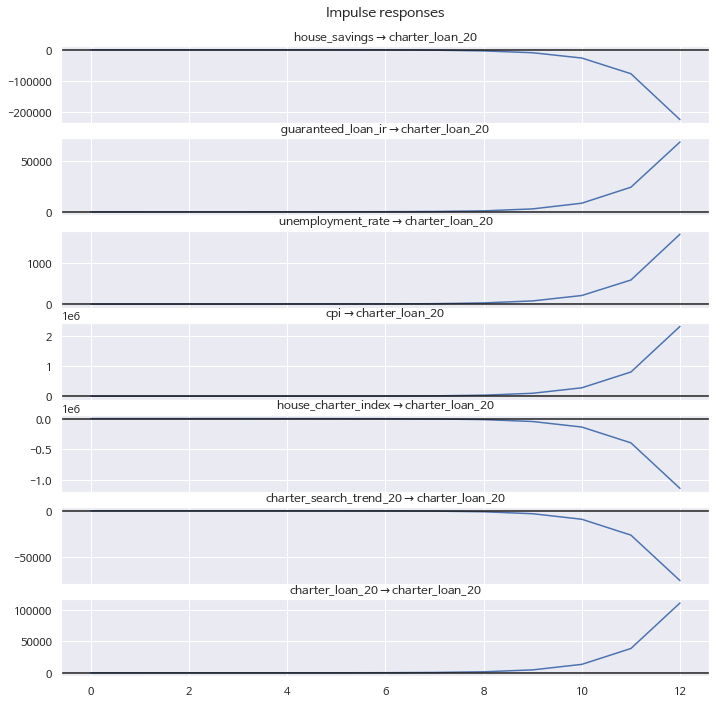

In [106]:
num_periods = 12
ir = vecm_res.irf(periods=num_periods)
#ir.plot(orth=False, plot_stderr=False, figsize=(15, 15))
ir.plot(orth=False, plot_stderr=False, response='charter_loan_20')
None

## Diagnostics

### Testing for nonormality

In [107]:
norm_test = vecm_res.test_normality()
norm_test.summary()

Test statistic,Critical value,p-value,df
6.742,23.68,0.944,14


### Checking for residual autocorrelation

In [108]:
white_test = vecm_res.test_whiteness(nlags=12, adjusted=True)
white_test.summary()

Test statistic,Critical value,p-value,df
487.5,491.0,0.062,441
